In [49]:
!pip install scikit-learn matplotlib

In [50]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Feature Extraction

In [51]:
with open("user-wallet-transactions (1).json", "r") as f:
    data = json.load(f)

wallets = {}

action_map = {
    'deposit': 'deposit',
    'borrow': 'borrow',
    'repay': 'repay',
    'redeemunderlying': 'redeem',
    'liquidationcall': 'liquidation'
}

for txn in data:
    user = txn.get('userWallet') or txn.get('actionData', {}).get('userId')
    action = txn.get('action', '').lower()

    if not user or not action:
        continue

    action_key = action_map.get(action)
    if not action_key:
        continue

    if user not in wallets:
        wallets[user] = {
            'wallet': user,
            'deposit': 0,
            'borrow': 0,
            'repay': 0,
            'redeem': 0,
            'liquidation': 0,
            'total_txns': 0
        }

    wallets[user][action_key] += 1
    wallets[user]['total_txns'] += 1

df = pd.DataFrame(wallets.values())
df.head()

,wallet,deposit,borrow,repay,redeem,liquidation,total_txns
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,0,0,0,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,0,0,0,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0,0,0,0,2
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,0,0,17,0,17
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,15,4,130,0,399


In [52]:
df['simulated_score'] = (
    df['deposit'] * 10 +
    df['repay'] * 15 +
    df['borrow'] * 5 +
    df['redeem'] * 5 -
    df['liquidation'] * 20 +
    df['total_txns'] * 2
).clip(0, 1000)

# Training Model

In [53]:
features = ['deposit', 'borrow', 'repay', 'redeem', 'liquidation', 'total_txns']
X = df[features]
y = df['simulated_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))

MSE: 493.7590829064506


In [54]:
df['predicted_score'] = model.predict(X)
df['predicted_score'] = df['predicted_score'].clip(0, 1000).round().astype(int)

In [55]:
wallet_scores = dict(zip(df['wallet'], df['predicted_score']))

with open("wallet_scores_ml.json", "w") as f:
    json.dump(wallet_scores, f, indent=2)

# PLOTTING

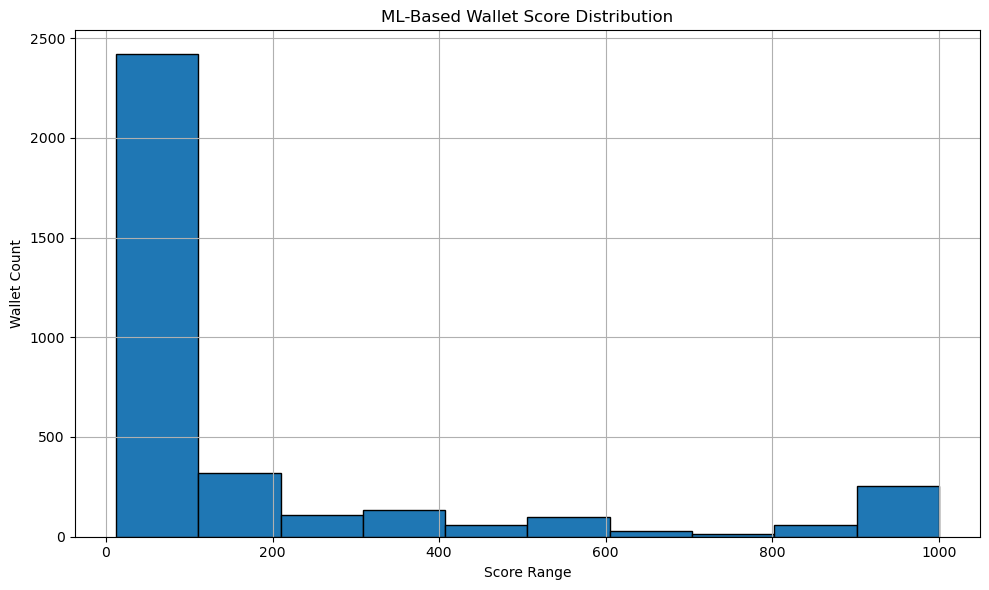

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(df['predicted_score'], bins=10, edgecolor='black')
plt.title("ML-Based Wallet Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("score_distribution_ml.png")
plt.show()